In [2]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import roc_auc_score  # or accuracy_score for classification
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import gc

In [3]:
train_df = pd.read_parquet("../data/train_clean_v3.parquet")
test_df = pd.read_parquet("../data/test_clean_v3.parquet")
test_df = test_df.reset_index()

In [4]:
TARGET_COL = "label"

X = train_df.drop(columns=[TARGET_COL])
y = train_df[TARGET_COL]

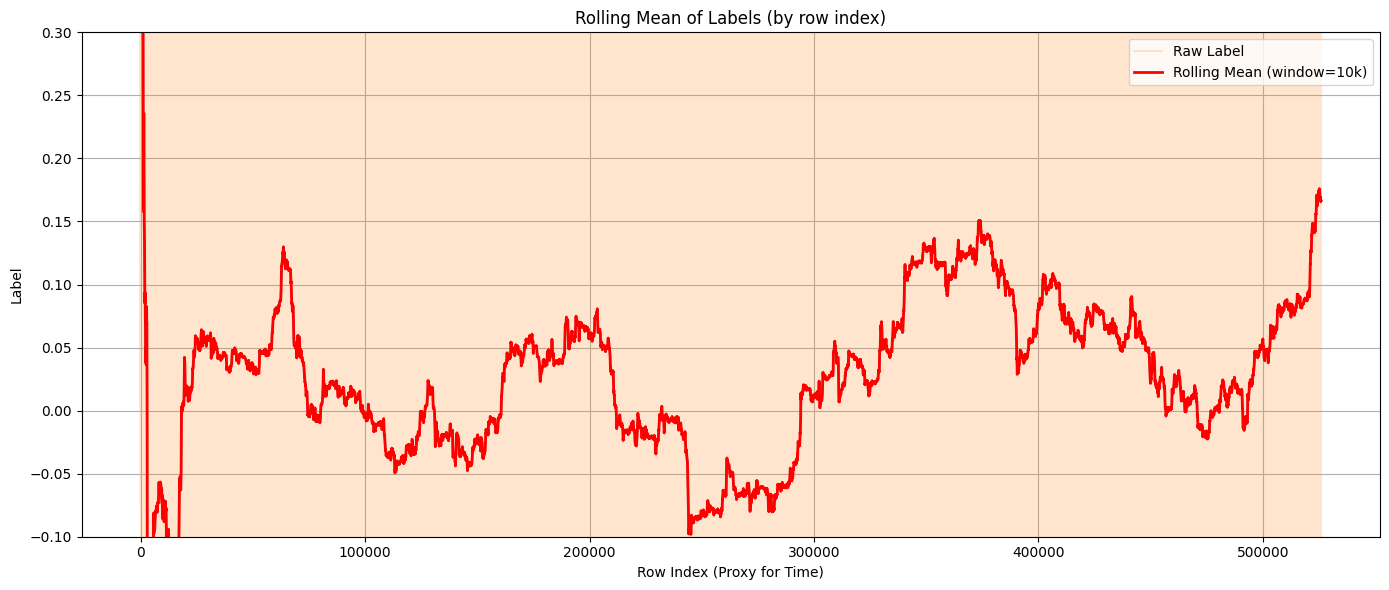

In [ ]:
rolling_mean = train_df["label"].rolling(window=50000, min_periods=1000).mean()

plt.figure(figsize=(14, 6))
plt.plot(rolling_mean)
plt.ylim(-0.1, 0.3)
plt.plot(train_df.index, train_df["label"], alpha=0.2, label="Raw Label")
plt.plot(train_df.index, rolling_mean, color="red", linewidth=2, label="Rolling Mean (window=10k)")
plt.title("Rolling Mean of Labels (by row index)")
plt.xlabel("Row Index (Proxy for Time)")
plt.ylabel("Label")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
early = train_df["label"].iloc[:100000]
late = train_df["label"].iloc[-100000:]
print("Early mean:", early.mean())
print("Late mean:", late.mean())

Early mean: 0.016638521
Late mean: 0.07464938


Chunk 0: mean=0.0117, std=0.9777
Chunk 1: mean=-0.0080, std=1.0277
Chunk 2: mean=0.0597, std=0.9835
Chunk 3: mean=0.0811, std=1.0465


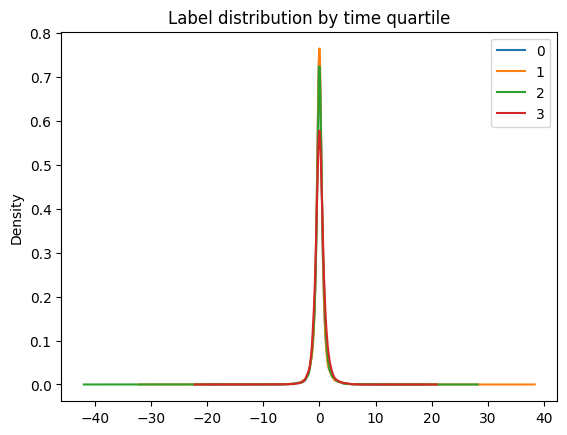

In [7]:
train_df["bin"] = pd.qcut(train_df.index, 4, labels=False)
train_df.groupby("bin")["label"].plot(kind="kde", legend=True, title="Label distribution by time quartile")

for i in range(4):
    subset = train_df.iloc[i * len(train_df) // 4:(i + 1) * len(train_df) // 4]
    print(f"Chunk {i}: mean={subset['label'].mean():.4f}, std={subset['label'].std():.4f}")


In [ ]:
split_idx = int(len(X) * 0.9)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]
X_val = X.iloc[split_idx:]
y_val = y.iloc[split_idx:]

In [9]:
assert X_train.index.max() < X_val.index.min()

In [10]:
print("Train mean:", y_train.mean())
print("Val mean:", y_val.mean())

Train mean: 0.02247898
Val mean: 0.15894897


In [11]:
def pearson_corr_metric(preds, data):
    y_true = data.get_label()
    return 'pearson', np.corrcoef(y_true, preds)[0, 1], True

In [12]:
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_val, label=y_val)

params = {
    "objective": "regression",
    "metric": "rmse",
    "device": "gpu",
    "gpu_platform_id": 0, # gpu accelerated
    "gpu_device_id": 0,
    "verbosity": 1
}

params.update({
    # "learning_rate": 0.01,
    # "num_leaves": 31, # same as lightgbm default
    # "max_depth": 6, 
    # "min_data_in_leaf": 50, 
    # "reg_alpha": 1.0,
    # "reg_lambda": 1.0,
    # "subsample": 0.8,
    # "colsample_bytree": 0.8
})


model = lgb.train(
    params,
    dtrain,
    num_boost_round=3000,
    valid_sets=[dval],
    valid_names=["val"],
    callbacks=[
        log_evaluation(period=100)
    ]
)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 221333
[LightGBM] [Info] Number of data points in the train set: 473298, number of used features: 868
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 5070 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 784 dense feature groups (353.88 MB) transferred to GPU in 0.048097 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.022479
[100]	val's rmse: 1.11992
[200]	val's rmse: 1.15977
[300]	val's rmse: 1.18029
[400]	val's rmse: 1.19688
[500]	val's rmse: 1.20493
[600]	val's rmse: 1.21165
[700]	val's rmse: 1.21942
[800]	val's rmse: 1.22695
[900]	val's rmse: 1.23136
[1000]	val's rmse: 1.23531
[1100]	val's rmse: 1.23937
[1200]	val's rmse: 1.24148
[1300]	val's rmse: 1.24378
[1400]	

In [13]:
# get predictions
y_pred = model.predict(X_val)

# get pearson corr for prediction
pearson_corr, _ = pearsonr(y_val, y_pred)
print(f"Pearson correlation: {pearson_corr:.4f}")

Pearson correlation: 0.0344


In [14]:
test_df

,level_0,index,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,...,X882,X883,X884,X885,X886,X887,X888,X889,X890,label
0,0,0,0.114014,12.117188,10.585938,10.968750,21.56250,-0.732910,0.512207,-0.041992,...,1.014648,1.367188,1.583984,1.583984,1.583984,1.583984,1.568359,1.426758,2.193359,0.0
1,1,1,2.425781,2.962891,136.250000,12.304688,148.50000,-0.337891,-0.412109,-0.259521,...,1.749023,1.848633,0.000131,0.000323,0.001746,0.007320,0.050934,0.142212,0.739746,0.0
2,2,2,1.084961,2.343750,23.390625,57.156250,80.56250,0.111267,0.458252,0.466797,...,1.705078,1.772461,0.000550,0.003597,0.009262,0.019943,0.072510,0.169678,0.808105,0.0
3,3,3,14.796875,1.117188,116.500000,13.078125,129.62500,-0.149414,-0.640625,-0.873535,...,0.931152,1.038086,1.381836,1.381836,1.381836,1.381836,1.381836,1.363281,2.464844,0.0
4,4,4,0.032990,14.179688,43.812500,49.843750,93.62500,-0.694824,0.611328,0.067688,...,1.080078,1.141602,0.000363,0.012718,0.137573,0.464111,1.050781,1.268555,2.498047,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538145,538145,538145,8.601562,2.326172,74.562500,42.687500,117.25000,0.198730,0.135498,0.505371,...,2.185547,2.257812,1.239258,0.646484,0.368164,0.196899,0.074036,0.059845,0.245117,0.0
538146,538146,538146,5.027344,7.296875,45.062500,19.156250,64.18750,-0.451660,-0.433594,-0.232788,...,1.776367,1.724609,0.000021,0.000027,0.000029,0.000083,0.049500,0.274902,1.163086,0.0
538147,538147,538147,12.781250,1.053711,23.921875,38.281250,62.21875,0.574219,0.482178,1.076172,...,1.340820,1.420898,0.000600,0.005741,0.089661,0.374268,0.977539,1.223633,2.455078,0.0
538148,538148,538148,4.316406,1.407227,51.468750,111.687500,163.12500,-0.561035,-0.324219,-0.355957,...,2.742188,3.035156,0.000089,0.000102,0.000153,0.000628,0.021698,0.044342,0.180908,0.0


In [19]:
test_preds = model.predict(test_df.drop(columns=["level_0", "label", "index"]))

submission = pd.DataFrame({
    "ID": np.arange(len(test_df)),
    "prediction": test_preds
})

submission.to_csv("../data/preds/lightgbm_test_preds.csv", index=False)


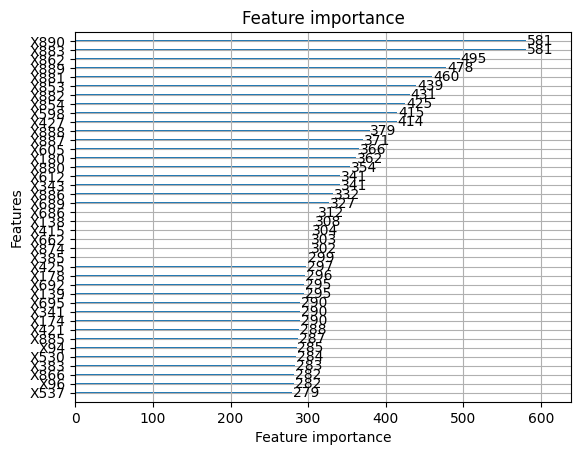

In [20]:
import matplotlib.pyplot as plt

lgb.plot_importance(model, max_num_features=40)
plt.show()

In [ ]:
importance_df = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance(importance_type='gain')
})

# sort by importance
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
importance_df.to_csv("../data/resources/lgbm_feature_importance.csv", index=False)

print(importance_df.head(40))


   feature    importance
0     X862  45173.554627
1     X784  38652.732619
2     X466  33309.233735
3     X890  33175.642506
4     X889  27633.514261
5     X854  24729.166224
6     X344  23406.165796
7     X883  22641.714179
8     X343  22477.921367
9     X853  21312.513356
10    X425  19082.070424
11    X692  18457.519794
12    X689  18256.135194
13    X695  17622.649923
14    X530  17566.490328
15    X598  17085.035853
16    X537  16671.045427
17    X887  16638.147466
18    X886  16347.767303
19    X136  16258.505181
20    X178  16169.543111
21    X385  16166.978980
22    X686  15914.862110
23    X888  15487.216210
24    X341  15479.987293
25    X540  15165.479070
26    X873  14903.598117
27    X174  14813.709732
28    X696  14545.146362
29    X421  14281.093160
30    X605  14141.298942
31     X97  14079.449874
32    X284  13948.788605
33    X465  13933.058149
34    X383  13655.898237
35    X612  13393.283563
36    X428  13315.424925
37    X180  13214.968130
38    X868  12999.856683


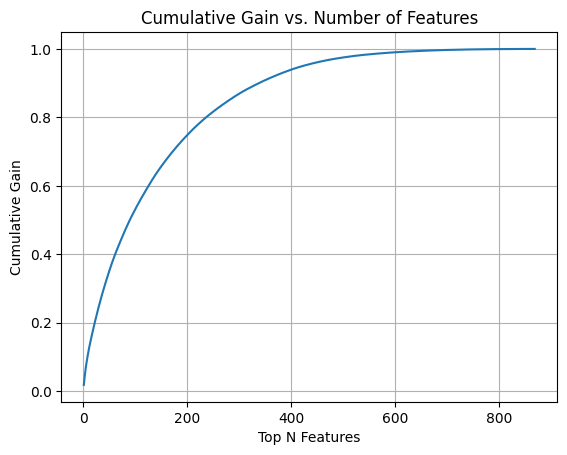

In [23]:
cumulative_gain = np.cumsum(importance_df["importance"]) / importance_df["importance"].sum()

plt.plot(range(1, len(cumulative_gain)+1), cumulative_gain)
plt.xlabel("Top N Features")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain vs. Number of Features")
plt.grid(True)
plt.show()
